In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")



/home/joseph/anaconda3/envs/fraud-detection/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/joseph/anaconda3/envs/fraud-detection/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/joseph/anaconda3/envs/fraud-detection/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/joseph/anacon

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


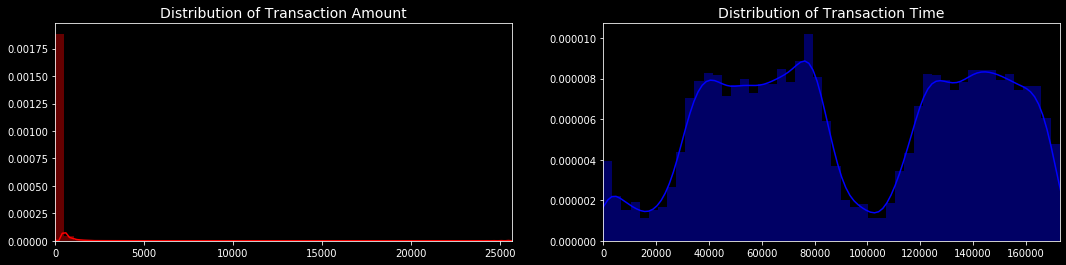

In [2]:
df = pd.read_csv('/tmp/creditcard.csv')

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

fig, ax = plt.subplots(1, 2, figsize=(18,4))
amount_val = df['Amount'].values
time_val = df['Time'].values
sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
plt.show()


In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)



In [4]:
colors = ["#0101DF", "#DF0101"]
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


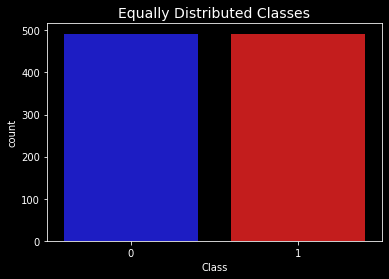

In [5]:
df = df.sample(frac=1)
# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))
sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


In [6]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))


Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -18.8220867423816, -19.2143254902614, -18.049997689859396]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.4311310279993, -18.553697009645802, -18.683714633344298, -18.047596570821604]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-15.2399619587112, -

T-SNE took 4.3 s
PCA took 0.0088 s
Truncated SVD took 0.0025 s


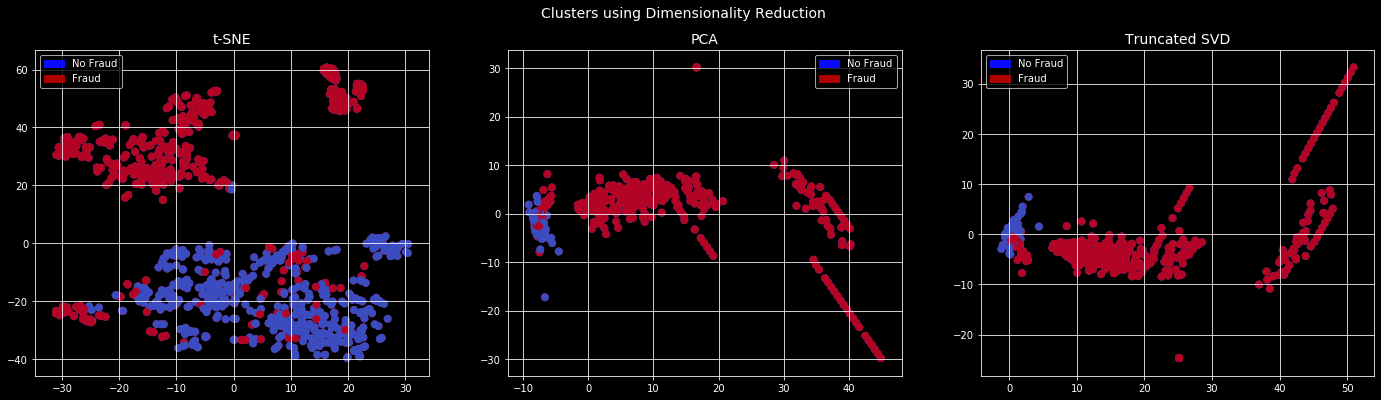

In [7]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])
plt.show()


In [8]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')



Logistic Regression Cross Validation Score:  94.72%
